## Worksheet 3

### Group 22 Eaton Heidegger and Shannon Schröder

### 1. Convergence Order of ODE integration schemes

#### 1.1 Implementation of different Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# ODE
def f(x, y):
    return (1- y) * y

In [ ]:
# Derivative of f
def df(x, y):
    return 1 - 2 * y

In [ ]:
# Exact solution
def exact_solution(x, y0):
    return 1 / (1 + ((1 - y0) / y0) * np.exp(-x))

In [ ]:
# Forward Euler method
def forward_euler(f, x, y, h):
    return y + h * f(x, y)

Simple method that is only first order accurate $O(h)$, meaning it gets more accurate as $h$ decreases, but not very fast. It is an explicit method, simple to use but can become unstable for higher $h$.

In [ ]:
# Backward Euler method
def backward_euler(f, df, x, y, h, eps=1e-4):
    xp = x + h
    yp = y

    while True:
        ypnext = yp - (yp - y - h * f(xp, yp)) / (1 - h * df(xp, yp))
        if np.abs(ypnext - yp) < eps:
            break
        yp = ypnext
    return ypnext

Implicit method, requiring iterative Newton's method to solve. It is more stable than the forward Euler method, but is also only first order accurate $O(h)$.

In [ ]:
# Crank-Nicolson method
def crank_nicolson(f, df, x, y, h, eps=1e-4):
    xp = x + h
    yp = y

    while True:
        ypnext = yp - (yp - y - h/2 * (f(xp, yp) + f(x, y))) / (1 - h/2 * df(xp, yp))
        if np.abs(ypnext - yp) < eps:
            break
        yp = ypnext
    return ypnext

Second-order accurate $O(h^2)$, meaning it converges to the true solution faster than Euler methods. Uses average slope instead of just forward differences.

In [ ]:
# Heun's Runge-Kutta 2nd order method
def rk2(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h, y + h * k1)
    return y + h/2 * (k1 + k2)

Uses two slopes ($k1$ and $k2$) to estimate the next value. Second-order accurate $O(h^2)$.

In [ ]:
# Runge-Kutta 4th order method
def rk4(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h/2, y + h/2 * k1)
    k3 = f(x + h/2, y + h/2 * k2)
    k4 = f(x + h, y + h * k3)
    return y + h/6 * (k1 + 2*k2 + 2*k3 + k4)

Fourth order accurate $O(h^4)$, meaning errors decrease much faster than other methods. Most accurate of the methods implemented.

In [ ]:
# Main function to solve the ODE using different methods
def solve_ode(method, f, df, x0, y0, h, x_end):
    x_values = np.arange(x0, x_end + h, h)
    y_values = np.zeros_like(x_values)
    y_values[0] = y0

    for i in range(1, len(x_values)):
        x, y = x_values[i - 1], y_values[i - 1]
        if method == "forward_euler":
            y_values[i] = forward_euler(f, x, y, h)
        elif method == "backward_euler":
            y_values[i] = backward_euler(f, df, x, y, h)
        elif method == "crank_nicolson":
            y_values[i] = crank_nicolson(f, df, x, y, h)
        elif method == "rk2":
            y_values[i] = rk2(f, x, y, h)
        elif method == "rk4":
            y_values[i] = rk4(f, x, y, h)
    
    return x_values, y_values

Here, we iterate over time steps to compute $y(x)$, storing the results in y_values. The method used depends on the input, allowing us to compare different numerical approaches.

In [ ]:
# Parameters
x0 = 0
y0 = 0.1
h = 0.1
x_end = 4

In [ ]:
# Solve the ODE using different methods
methods = ["forward_euler", "backward_euler", "crank_nicolson", "rk2", "rk4"]
solutions = {method: solve_ode(method, lambda x, y: y - y**2, lambda x, y: 1 - 2*y, x0, y0, h, x_end) for method in methods}

Each method is defined separately and then used within the ODE solver, which runs the solver for each method and stores the results.

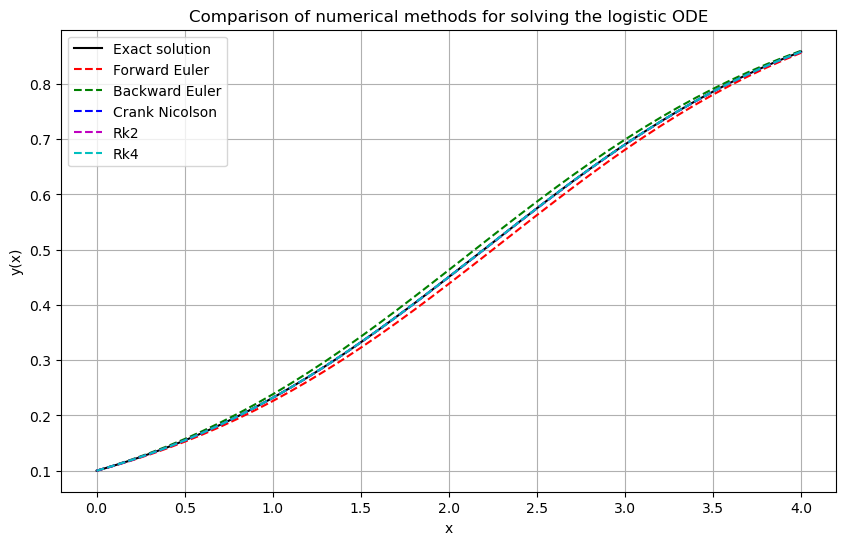

In [ ]:
# Plotting the results
x_exact = np.linspace(x0, x_end, 200)
y_exact = exact_solution(x_exact, y0)

plt.figure(figsize=(10, 6))
plt.plot(x_exact, y_exact, "k-", label="Exact solution")

colors = ["r", "g", "b", "m", "c"]
for method, color in zip(methods, colors):
    x, y = solutions[method]
    plt.plot(x, y, "--", label=method.replace("_", " ").title(), color=color)

plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Comparison of numerical methods for solving the logistic ODE")
plt.legend()
plt.grid()
plt.show()

In the result we can see, Crank-Nicolson, Heun's RK2, and RK4 all closely follow the exact solution, meaning they are very accurate. Forward Euler consistently undershoots the exact solution, making it less reliable. Backward Euler overshoots the exact solution, which also makes it less accurate. This behavior aligns with our expectations.

#### 1.2 Local Truncation error

Each method has a theoretical truncation error per step:
- Forward Euler: $O(h)$
- Backward Euler: $O(h)$
- Crank-Nicolson: $O(h^2)$
- Heun's RK2: $O(h^2)$
- RK4: $O(h^4)$

Since we're plotting on a log-log scale, we expect:
- Forward and backward Euler to have a slope of $1$
- Crank-Nicolson and RK2 to have slopes of $2$
- RK4 to have a slope of $4$

We'll iterate over different values of $h$ from $10^{-3}$ to $10^{-1}$, compute the error for a single step, and plot the results.

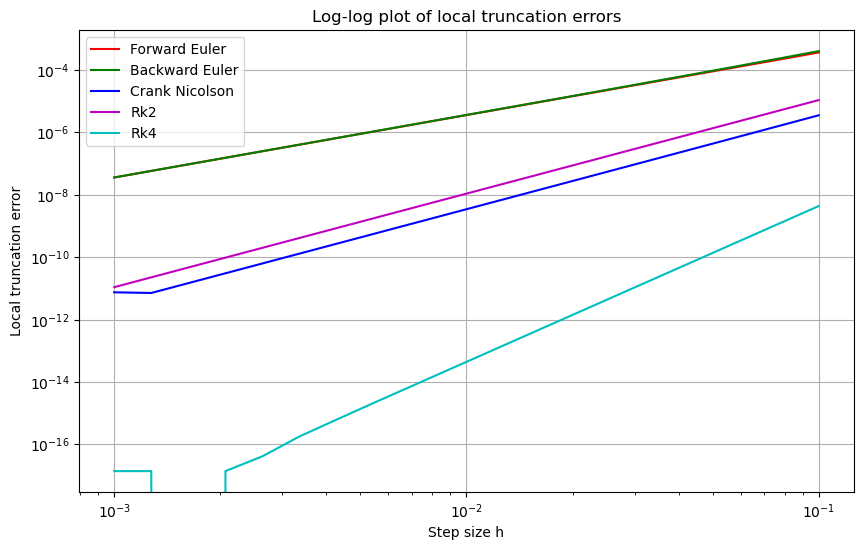

In [36]:
y0 = 0.1
h_values = np.logspace(-3, -1, 20)
errors = {method: [] for method in methods}

for h in h_values:
    y_exact = exact_solution(h, y0)

    errors["forward_euler"].append(np.abs(forward_euler(f, 0, y0, h) - y_exact))
    errors["backward_euler"].append(np.abs(backward_euler(f, df, 0, y0, h) - y_exact))
    errors["crank_nicolson"].append(np.abs(crank_nicolson(f, df, 0, y0, h) - y_exact))
    errors["rk2"].append(np.abs(rk2(f, 0, y0, h) - y_exact))
    errors["rk4"].append(np.abs(rk4(f, 0, y0, h) - y_exact))

plt.figure(figsize=(10, 6))
for method, color in zip(methods, colors):
    plt.loglog(h_values, errors[method], label=method.replace("_", " ").title(), color=color)

plt.xlabel("Step size h")
plt.ylabel("Local truncation error")
plt.title("Log-log plot of local truncation errors")
plt.legend()
plt.grid()
plt.show()

Our results show, that the Forward Euler and backward Euler methods have a slope of $1$. The Crank-Nicholson and Heun's RK2 methods have a slope of $2$. The RK4 method has a steeper slope, around $4$, confirming its fourth-order accuracy. 

As expected, RK4 has the smallest error, followed by Crank-Nicholson and Heun's RK2, and finally Euler methods with the largest error. This means that for the same step size $h$, higher-order methods give more accurate results. For very small $h$, RK4’s error flattens, likely due to floating-point precision limits. A slight dip can be seen in the curve for the RK2 and a more prominent dip in the curve for RK4. This dips may indicate numerical precision limits. These could be due to floating points precision limits. When the step size $h$ becomes very small, the local truncation error should theoretically keep decreasing. However, in practical computations, floating-point arithmetic has finite precision. At very small $h$, the truncation error becomes smaller than machine precision, and round-off errors dominate, leading to artificially increased errors after the dip. These dips could also be due to that RK2 and RK4 involve multiple floating-point operations per step (especially RK4 with four intermediate calculations). When subtracting two nearly equal numbers (like in error computation), rounding errors may accumulate, creating artificial dips before the error starts increasing again.

This result suggest, that for high accuracy, RK4 is the best choice. For a a balance of efficiency and accuracy, Crank-Nicholson or Heun's RK2 might be preferred. Forward and backward Euler are not very accurate, but are simple and sometimes useful for rough approximations.

#### 1.3 Global Truncation Error

Unlike the local truncation error (which only looks at one step), the global truncation error accumulates over multiple steps.

Since we're fixing $x_{max} = 0.2$ and varying the number of steps $N$, the step size is given by:

$h = \frac{x_{max}}{N}$

Thus, as $N$ increases (or equivalently, as $h$ decreases), the global error should scale accordingly:

Global error $\approx Ch^p = C (\frac{x_{max}}{N})^p$, where $p$ is the order of the method.

To implement this we fix $x_{max} = 0.2$ and vary the number of steps $N$. We compute $h = x_{max} / N$ and integrate each method to $x_{max}$. We then compute the absolute error

$\epsilon_{global} = |y_{num}(x_{max} - y_{exact}(x_{max}))$

and plot the error vs. h in a log-log plot.

In [37]:
def integrate(method, f, df, x_max, y0, N):
    h = x_max / N
    x, y = 0,y0

    for i in range(N):
        if method == "forward_euler":
            y = forward_euler(f, x, y, h)
        elif method == "backward_euler":
            y = backward_euler(f, df, x, y, h)
        elif method == "crank_nicolson":
            y = crank_nicolson(f, df, x, y, h)
        elif method == "rk2":
            y = rk2(f, x, y, h)
        elif method == "rk4":
            y = rk4(f, x, y, h)
        x += h
    return y

The integrate function, iterates over a given number of steps to compute $y(x)$ for a given range. Each numerical method is applied depending on user choice.

To compute the global truncation error, we fix $x_max = 0.2$ and vary the number of steps.

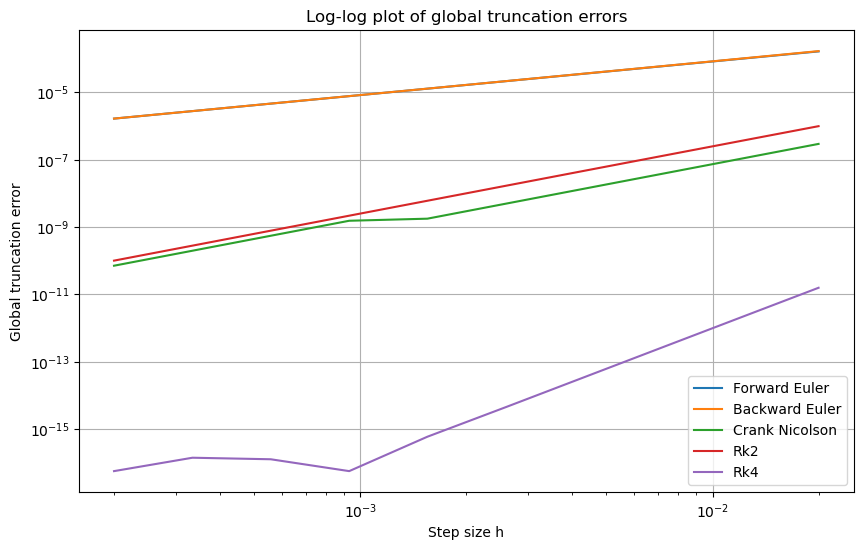

In [38]:
y0 = 0.1
x_max = 0.2
N_values = np.logspace(1, 3, 10, dtype=int)
h_values = x_max / N_values
errors = {method: [] for method in methods}

for N in N_values:
    y_exact = exact_solution(x_max, y0)
    for method in errors:
        y_num = integrate(method, f, df, x_max, y0, N)
        errors[method].append(np.abs(y_num - y_exact))

plt.figure(figsize=(10, 6))
for method, err in errors.items():
    plt.loglog(h_values, err, label=method.replace("_", " ").title())

plt.xlabel("Step size h")
plt.ylabel("Global truncation error")
plt.title("Log-log plot of global truncation errors")
plt.legend()
plt.grid()
plt.show()

In our results the slopes are the same as in our results for the local truncation errors. RK4 has the smallest error, while forward and backward Euler have the largest. The small dips in RK2 and RK4 are mostly likely due to floating-point precision, similiarly to the local truncation errors.